# 2D Visualization

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes

import IPython

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

#%matplotlib ipympl

In [2]:
dataset = pd.read_csv('kindle_data-v2.csv')

df = dataset.drop(['asin', 'imgUrl', 'productURL', 'category_id'], axis=1)
df.publishedDate = pd.to_datetime(dataset.publishedDate)

X = df.drop(['title', 'author', 'soldBy'], axis=1).copy()
X['soldByAmazon'] = df.soldBy.str.contains('Amazon')
X

,stars,reviews,price,isKindleUnlimited,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name,soldByAmazon
0,4.8,0,9.99,False,True,False,False,2015-06-01,Parenting & Relationships,True
1,4.4,0,16.99,False,False,False,False,2022-02-15,Parenting & Relationships,False
2,4.8,0,16.99,False,False,True,False,2022-09-13,Parenting & Relationships,False
3,4.2,0,9.95,True,False,True,False,2020-02-25,Parenting & Relationships,False
4,4.7,0,13.99,False,False,False,False,2015-05-05,Parenting & Relationships,False
...,...,...,...,...,...,...,...,...,...,...
133097,4.7,0,0.00,False,True,False,False,2023-09-15,Nonfiction,False
133098,4.4,0,9.99,False,False,False,False,2021-09-30,Nonfiction,True
133099,4.8,0,1.99,False,True,False,False,2023-09-15,Nonfiction,False
133100,4.7,0,0.00,False,True,False,False,2023-08-25,Nonfiction,False


## Setup

In [3]:
def echo(df):
    print(df)
    return df
EchoTransformer = FunctionTransformer(echo)

def custom_date_transform(df):
    out = pd.DataFrame()
    for col in df.columns:
        out[col] = df[col].dt.year + ((df[col].dt.month-1)/12)
    return out
CustomDateTransformer = FunctionTransformer(custom_date_transform)

def zero_to_na_transform(df):
    return df[['price', 'reviews']].replace(0, np.nan)
ZeroToNaTransformer = FunctionTransformer(zero_to_na_transform)

def wrap_model(scaler=StandardScaler, encoder=lambda:OneHotEncoder(sparse_output=False), imputer=lambda:SimpleImputer(strategy="median"), transformers=[], poly=False):
    def inner(model):
        return make_pipeline(
            *transformers,
            make_column_transformer(
                (
                    make_pipeline(
                        *([imputer() if imputer else []]),
                        scaler(),
                    ), make_column_selector(dtype_include=[np.number, bool])
                ),
                (
                    make_pipeline(
                        CustomDateTransformer,
                        *([imputer() if imputer else []]),
                        scaler(),
                    ), make_column_selector(dtype_include='datetime')
                ),
                (encoder(), make_column_selector(dtype_include=object)),
            ), 
            *([PolynomialFeatures(2, interaction_only=True)] if poly else []), 
            model
        )
    return inner

def pt_pipeline():
    return make_pipeline(
        StandardScaler(),
        PowerTransformer()
    )

def scatter3D(df,x,y,z,hue):
    ax = plt.gca()
    for h in np.unique(hue):
        gdf = df[hue==h]
        plt.scatter(gdf[x],gdf[y],gdf[z],label=h)
    return ax

def cluster_visualize(X, cluster=KMeans(n_clusters=5, n_init='auto'), pca_dims=2, preprocess=wrap_model()):
    km = preprocess(cluster).fit(X)
    groups = km[-1].labels_
    
    pca = preprocess(PCA(n_components=pca_dims)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))
    ax = None
    if pca_dims == 3:
        ax = scatter3D(pca_out, x=0, y=1, z=2, hue=groups)
    else:
        ax = sns.scatterplot(pca_out, x=0, y=1, hue=groups, palette='deep')
    return ax

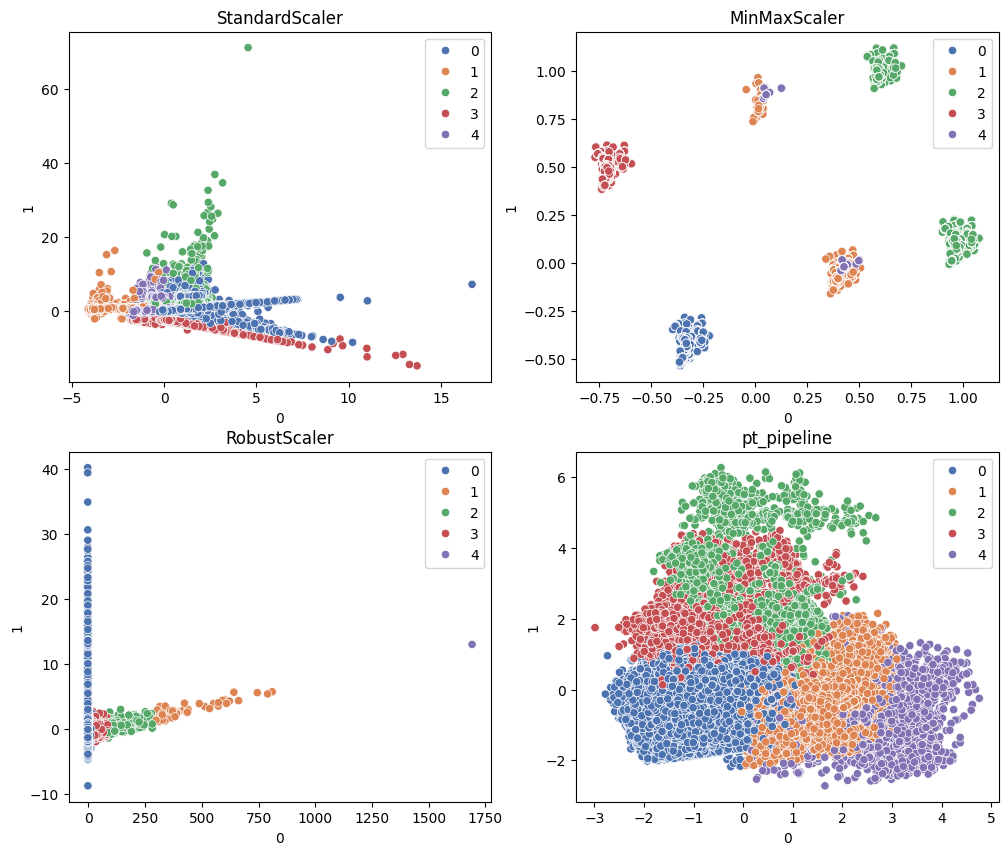

In [4]:
plt.figure(figsize=(12,10))
for i, scaler in enumerate([StandardScaler, MinMaxScaler, RobustScaler, pt_pipeline]):
    plt.subplot(2, 2, i+1)
    cluster_visualize(X, preprocess=wrap_model(scaler)).set_title(scaler.__name__)

In [90]:
pca = wrap_model(scaler=StandardScaler)(PCA(n_components=2)).fit(X)
pca_out = pd.DataFrame(pca.transform(X))
comps = pd.DataFrame(pca[-1].components_)
print(np.abs(comps).idxmax(axis=1))
np.abs(comps)

0    3
1    1
dtype: int64


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0.024200,0.025226,0.454602,0.687717,0.278795,0.185749,0.083905,0.367804,0.007629,0.012264,0.006045,0.005515,0.000522,0.005266,0.002379,0.005088,0.008484,0.016129,0.003568,0.001957,0.001259,0.010613,0.031811,0.020944,0.014177,0.010215,0.015790,0.000725,0.001256,0.011128,0.004534,0.008191,0.013349,0.022237,0.015782,0.003057,0.001081,0.012595,0.003347,0.171785,0.175967,0.004183
1,0.389467,0.569230,0.404265,0.012767,0.056177,0.405192,0.367499,0.159738,0.002622,0.020367,0.005400,0.012705,0.000465,0.017083,0.003934,0.004558,0.012851,0.020486,0.000778,0.001318,0.002329,0.000212,0.000889,0.029307,0.033985,0.011297,0.009684,0.001742,0.000231,0.002506,0.005403,0.005617,0.000132,0.012359,0.011185,0.002249,0.001478,0.021166,0.003309,0.104945,0.128917,0.023972


In [93]:
# Reviews outlier
dataset[pca_out[1] > 60]

,asin,title,author,soldBy,imgUrl,productURL,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name
28874,B078GD3DRG,Where the Crawdads Sing,Delia Owens,Penguin Group (USA) LLC,https://m.media-amazon.com/images/I/91nCsvKqE5...,https://www.amazon.com/dp/B078GD3DRG,4.7,618227,12.99,False,5,False,True,False,2018-08-14,Literature & Fiction


In [97]:
# Price outliers
dataset[pca_out[0] > 12]

,asin,title,author,soldBy,imgUrl,productURL,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name
15712,B09S3H9KWB,Youmans and Winn Neurological Surgery E-Book: ...,H. Richard Winn,Amazon.com Services LLC,https://m.media-amazon.com/images/I/81DPrUgIcc...,https://www.amazon.com/dp/B09S3H9KWB,4.1,0,636.99,False,15,False,False,False,NaN,Science & Math
123336,B0CFWJB1PX,Drugs in Litigation: Damage Awards Involving P...,LexisNexis Editorial Staff,Amazon.com Services LLC,https://m.media-amazon.com/images/I/419+UKcVsz...,https://www.amazon.com/dp/B0CFWJB1PX,0.0,0,682.00,False,20,False,False,False,2023-07-14,Law
123725,B017HM6F1Q,How to Write a Patent Application,Jeffrey G. Sheldon,Amazon.com Services LLC,https://m.media-amazon.com/images/I/71CQ6HRR39...,https://www.amazon.com/dp/B017HM6F1Q,3.5,0,629.00,False,20,False,False,False,2022-12-01,Law
125981,B006NYK31S,Broker-Dealer Regulation,Clifford E. Kirsch,Amazon.com Services LLC,https://m.media-amazon.com/images/I/717G-NmJz5...,https://www.amazon.com/dp/B006NYK31S,0.0,0,662.00,False,20,False,False,False,2023-07-01,Law
130517,B01K3LK4KG,Percy Jackson's Greek Gods by Rick Riordan (20...,NaN,NaN,https://m.media-amazon.com/images/I/51ARIl1BoW...,https://www.amazon.com/dp/B01K3LK4KG,4.8,0,14.90,False,25,False,False,False,1806-01-01,Children's eBooks


# Clipping

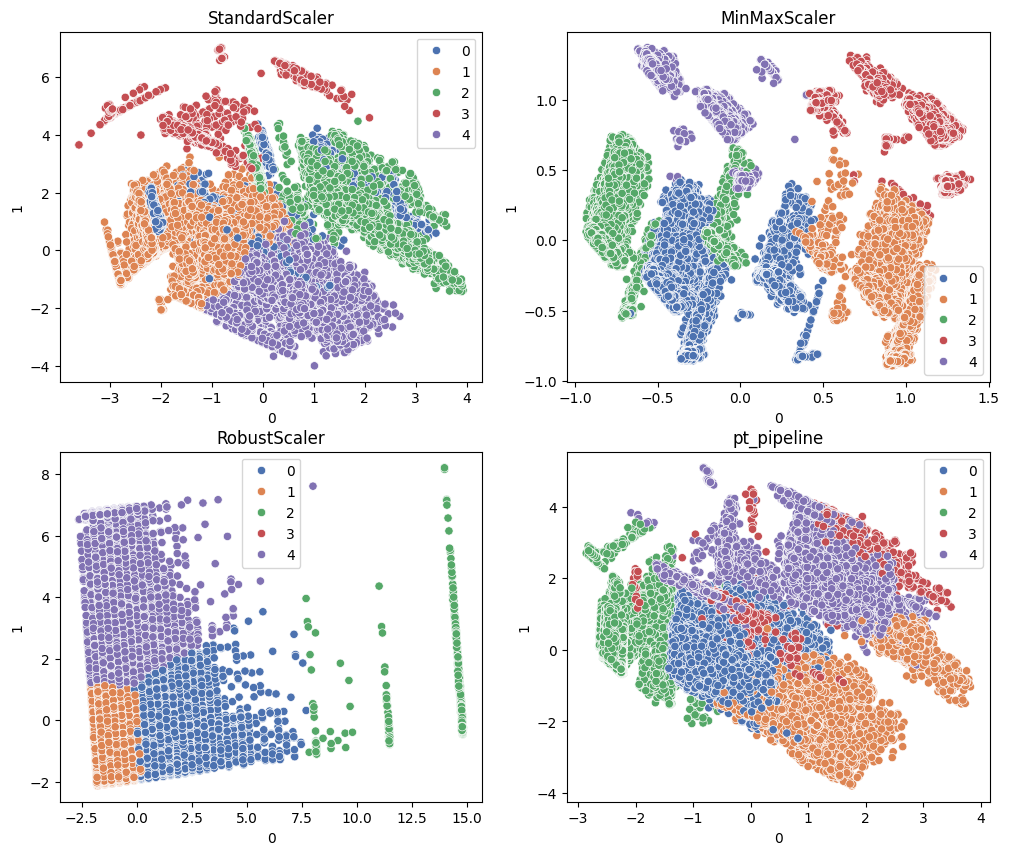

In [149]:
X2 = X.copy()
X2['reviewsClipped'] = X2.reviews > 365 
X2['priceClipped'] = X2.price > 15 
X2['dateClipped'] = X2.publishedDate.dt.year < 2000 
X2.reviews.clip(upper=365, inplace=True)
X2.price.clip(upper=15, inplace=True)
X2.publishedDate.clip(lower=pd.Timestamp('2000-01-01'), inplace=True)

plt.figure(figsize=(12,10))
for i, scaler in enumerate([StandardScaler, MinMaxScaler, RobustScaler, pt_pipeline]):
    plt.subplot(2, 2, i+1)
    cluster_visualize(X2, preprocess=wrap_model(scaler)).set_title(scaler.__name__)

In [144]:
pca = wrap_model(scaler=RobustScaler)(PCA(n_components=2)).fit(X2)
pca_out = pd.DataFrame(pca.transform(X2))
display(df[pca_out[0] < 7.5].describe())
display(df[pca_out[0] >= 7.5].describe())
# 0 Values seem to be the issue?

,stars,reviews,price,publishedDate
count,129772.000000,129772.000000,129772.000000,81565
mean,4.515488,910.144923,14.646655,2017-12-03 18:14:15.102066176
min,2.200000,0.000000,0.000000,1806-01-01 00:00:00
25%,4.400000,0.000000,4.990000,2014-12-09 00:00:00
50%,4.500000,9.000000,9.990000,2019-08-14 00:00:00
75%,4.700000,388.000000,14.550000,2022-04-14 00:00:00
max,5.000000,618227.000000,636.990000,2024-01-16 00:00:00
std,0.267950,5167.956509,20.677277,NaN


,stars,reviews,price,publishedDate
count,3330.000000,3330.000000,3330.000000,2521
mean,0.062853,0.049249,34.131204,2022-09-04 09:18:38.127727104
min,0.000000,0.000000,0.000000,1996-06-10 00:00:00
25%,0.000000,0.000000,7.990000,2022-11-17 00:00:00
50%,0.000000,0.000000,14.230000,2023-07-05 00:00:00
75%,0.000000,0.000000,40.067500,2023-09-11 00:00:00
max,2.100000,48.000000,682.000000,2023-11-14 00:00:00
std,0.308377,0.885775,52.588976,NaN


## Zero removal

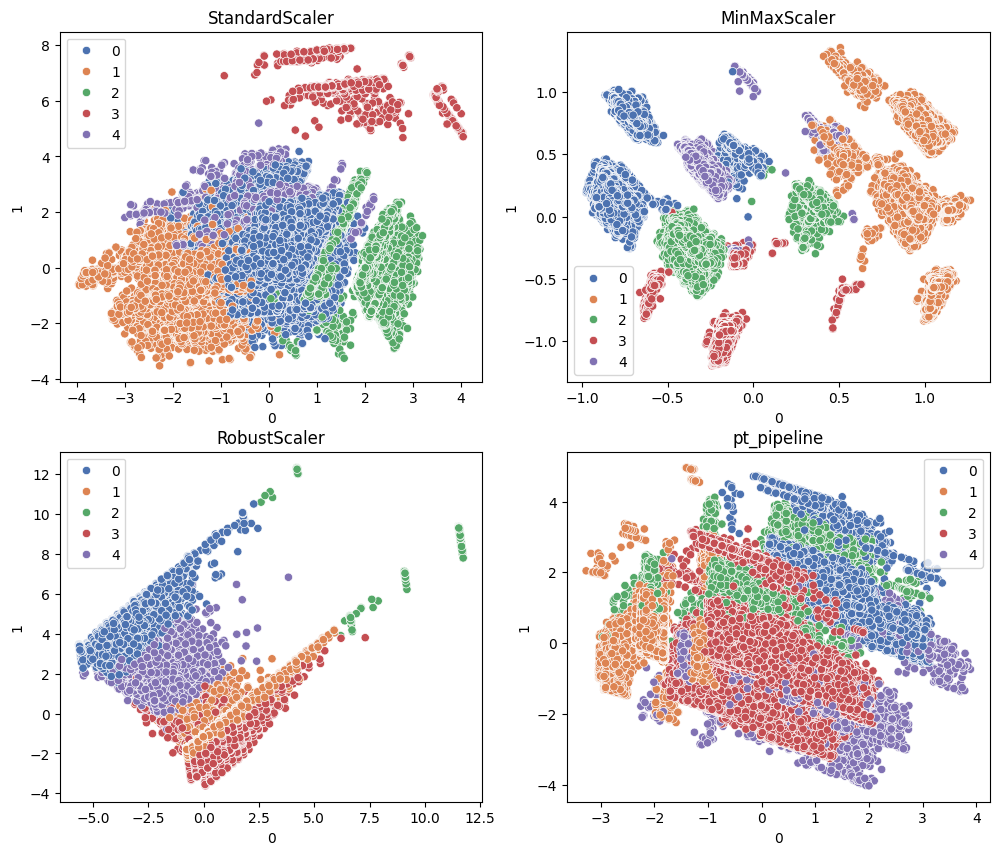

In [153]:
X2 = X.copy()
X2['reviewsClipped'] = X2.reviews > 365 
X2['priceClipped'] = X2.price > 15 
X2['dateClipped'] = X2.publishedDate.dt.year < 2000

X2.reviews.clip(upper=365, inplace=True)
X2.price.clip(upper=15, inplace=True)
X2.publishedDate.clip(lower=pd.Timestamp('2000-01-01'), inplace=True)

X2.reviews.replace(0, np.nan, inplace=True)
X2.price.replace(0, np.nan, inplace=True)

plt.figure(figsize=(12,10))
for i, scaler in enumerate([StandardScaler, MinMaxScaler, RobustScaler, pt_pipeline]):
    plt.subplot(2, 2, i+1)
    preprocess = wrap_model(scaler)
    cluster_visualize(X2, preprocess=preprocess).set_title(scaler.__name__)

In [157]:
pca = wrap_model(scaler=StandardScaler)(PCA(n_components=2)).fit(X2)
pca_out = pd.DataFrame(pca.transform(X2))
display(df[pca_out[1] < 4.5].describe())
display(df[pca_out[1] >= 4.5].describe())
# Seems to divide older from newer books, should be fine?

,stars,reviews,price,publishedDate
count,132198.000000,132198.000000,132198.000000,83182
mean,4.402992,889.687628,15.138122,2018-05-19 18:41:44.791902208
min,0.000000,0.000000,0.000000,2000-01-01 00:00:00
25%,4.400000,0.000000,4.990000,2015-04-28 00:00:00
50%,4.500000,4.000000,9.990000,2019-11-05 00:00:00
75%,4.700000,366.000000,14.990000,2022-06-14 00:00:00
max,5.000000,618227.000000,682.000000,2024-01-16 00:00:00
std,0.747638,5119.288350,22.303278,NaN


,stars,reviews,price,publishedDate
count,904.000000,904.000000,904.000000,904
mean,4.564602,549.298673,14.549989,1989-02-05 14:12:12.743362816
min,0.000000,0.000000,0.000000,1806-01-01 00:00:00
25%,4.500000,0.000000,8.990000,1987-01-06 00:00:00
50%,4.600000,0.000000,10.990000,1994-08-28 12:00:00
75%,4.700000,309.500000,14.990000,1998-03-25 06:00:00
max,5.000000,38930.000000,169.990000,2000-05-24 00:00:00
std,0.308261,2098.878614,13.433890,NaN


## Log transform

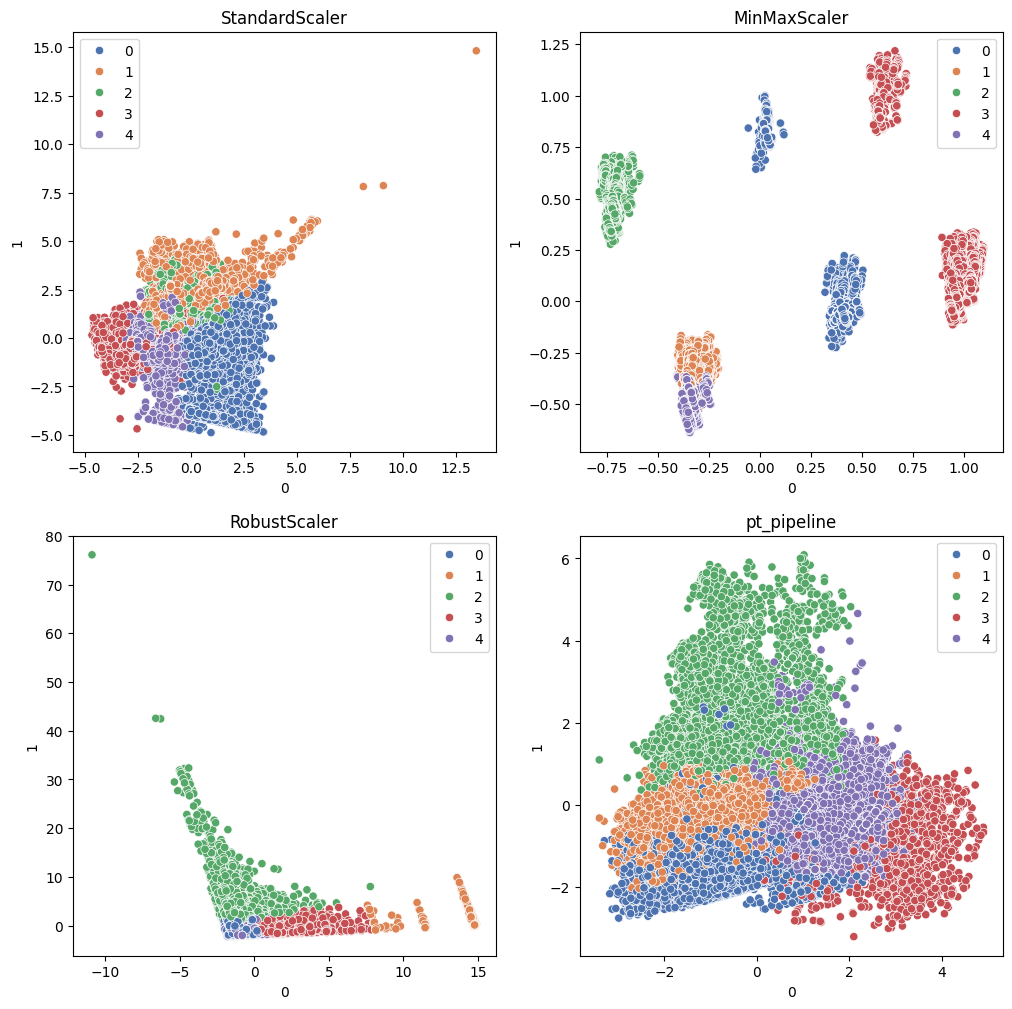

In [145]:
X2 = X.copy()
X2.reviews = np.log1p(X.reviews)
X2.price = np.log1p(X.price)
# publishedDate/stars skipped, not sure log would be applicable

plt.figure(figsize=(12,12))
for i, scaler in enumerate([StandardScaler, MinMaxScaler, RobustScaler, pt_pipeline]):
    plt.subplot(2, 2, i+1)
    cluster_visualize(X2, preprocess=wrap_model(scaler)).set_title(scaler.__name__)

In [122]:
pca = wrap_model(scaler=StandardScaler)(PCA(n_components=2)).fit(X2)
pca_out = pd.DataFrame(pca.transform(X))
df[pca_out[1] > 12.5].describe()
# Review outliers are problem here too

,stars,reviews,price,publishedDate
count,51201.000000,51201.000000,51201.000000,26033
mean,4.518146,2295.840921,9.856971,2016-12-20 20:17:14.932585472
min,2.200000,0.000000,0.000000,1806-01-01 00:00:00
25%,4.400000,249.000000,4.990000,2013-08-19 00:00:00
50%,4.500000,645.000000,8.990000,2018-06-19 00:00:00
75%,4.700000,1771.000000,11.990000,2021-07-20 00:00:00
max,5.000000,618227.000000,218.000000,2023-10-01 00:00:00
std,0.208202,8032.513915,8.352509,NaN
